In [ ]:
!pip install torch torchvision torchaudio

In [ ]:
!pip install rasterio geopandas albumentations segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.2 MB/s eta 0:00:00


In [ ]:
!pip install opencv-python matplotlib pillow

In [ ]:
!pip install awscli -q
!aws --version

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.2.3 requires docutils<0.22,>=0.20, but you have docutils 0.19 which is incompatible.
aws-cli/1.44.24 Python/3.12.12 Linux/6.6.105+ botocore/1.42.34


Ипортируем датасе space net дальше составив и другие изображения чтобы у меня был разный маштаб

In [ ]:
!mkdir -p spacenet_data
%cd spacenet_data

# SpaceNet 2 (Vegas, Paris, Shanghai, Khartoum)
#!wget "https://spacenet-dataset.s3.us-east-1.amazonaws.com/spacenet/SN2_buildings/tarballs/SN2_buildings_train_AOI_2_Vegas.tar.gz" -O SN2_buildings_train_AOI_2_Vegas.tar.gz
!wget "https://spacenet-dataset.s3.us-east-1.amazonaws.com/spacenet/SN2_buildings/tarballs/SN2_buildings_train_AOI_3_Paris.tar.gz" -O SN2_buildings_train_AOI_3_Paris.tar.gz
#!wget "https://spacenet-dataset.s3.us-east-1.amazonaws.com/spacenet/SN2_buildings/tarballs/SN2_buildings_train_AOI_4_Shanghai.tar.gz" -O SN2_buildings_train_AOI_4_Shanghai.tar.gz
#!wget "https://spacenet-dataset.s3.us-east-1.amazonaws.com/spacenet/SN2_buildings/tarballs/SN2_buildings_train_AOI_5_Khartoum.tar.gz" -O SN2_buildings_train_AOI_5_Khartoum.tar.gz

# SpaceNet 1 (Rio)
#!wget "https://spacenet-dataset.s3.us-east-1.amazonaws.com/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_3band.tar.gz" -O SN1_buildings_train_AOI_1_Rio_3band.tar.gz
#!wget "https://spacenet-dataset.s3.us-east-1.amazonaws.com/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz" -O SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz


/content/spacenet_data
--2026-01-26 15:09:19--  https://spacenet-dataset.s3.us-east-1.amazonaws.com/spacenet/SN2_buildings/tarballs/SN2_buildings_train_AOI_3_Paris.tar.gz
Resolving spacenet-dataset.s3.us-east-1.amazonaws.com (spacenet-dataset.s3.us-east-1.amazonaws.com)... 52.216.216.98, 52.216.10.102, 54.231.229.194, ...
Connecting to spacenet-dataset.s3.us-east-1.amazonaws.com (spacenet-dataset.s3.us-east-1.amazonaws.com)|52.216.216.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5726224966 (5.3G) [application/x-tar]
Saving to: ‘SN2_buildings_train_AOI_3_Paris.tar.gz’

SN2_buildings_train 100%[===================>]   5.33G  41.6MB/s    in 2m 15s  

2026-01-26 15:11:34 (40.3 MB/s) - ‘SN2_buildings_train_AOI_3_Paris.tar.gz’ saved [5726224966/5726224966]



In [ ]:
# распаковать, когда нужный файл докачался
!tar -xzf SN2_buildings_train_AOI_3_Paris.tar.gz

Делаем кастомный датасет и даталоадер

In [ ]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class SatelliteBuildingDataset(Dataset):
    def __init__(self, data_root, transform=None):
        self.data_root = Path(data_root)
        self.images_dir = self.data_root / 'AOI_3_Paris_Train' / 'RGB-PanSharpen'
        self.geojson_dir = self.data_root / 'AOI_3_Paris_Train' / 'geojson' / 'buildings'
        self.transform = transform

        self.images = sorted(self.images_dir.glob('*.tif'))
        print(f"✅ {len(self.images)} изображений SpaceNet 2 Paris загружено")

    def __len__(self):
        return len(self.images)

    def _load_image(self, img_path):
        with rasterio.open(img_path) as src:
            image = src.read([1, 2, 3]).transpose(1, 2, 0).astype(np.float32) / 255.0
            resolution = src.res
            return image, resolution

    def _geojson_to_mask(self, img_path, img_name):
        with rasterio.open(img_path) as src:
            transform = src.transform
            shape = src.shape[:2]

        base_name = Path(img_name).stem.replace('RGB-PanSharpen_', '')
        geojson_path = self.geojson_dir / f"buildings_{base_name}.geojson"

        if not geojson_path.exists():
            return np.zeros(shape, dtype=np.float32)

        gdf = gpd.read_file(geojson_path)
        if len(gdf) == 0:
            return np.zeros(shape, dtype=np.float32)

        shapes = [(geom, 1.0) for geom in gdf.geometry]
        mask = rasterize(shapes, out_shape=shape, transform=transform, fill=0.0, dtype=np.float32)
        return mask

    def __getitem__(self, index):
        img_name = self.images[index].name
        img_path = self.images[index]

        # Загружаем данные
        image_np, resolution = self._load_image(img_path)
        mask_np = self._geojson_to_mask(img_path, img_name)

        # Numpy → Tensor
        image_tensor = torch.from_numpy(image_np.transpose(2, 0, 1))  # [H,W,C] → [C,H,W]
        mask_tensor = torch.from_numpy(mask_np).unsqueeze(0)          # [H,W] → [1,H,W]

        # Трансформации
        if self.transform:
            image_tensor = self.transform(image_tensor)

        return {
            'image': image_tensor,
            'mask': mask_tensor,
            'resolution': resolution,
            'name': img_name
        }

# ✅ ТРАНСФОРМАЦИИ
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ✅ ИСПОЛЬЗОВАНИЕ
dataset = SatelliteBuildingDataset('/content/spacenet_data', transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

# ✅ ТЕСТ
sample = dataset[0]
print(f"✅ Image: {sample['image'].shape}")
print(f"✅ Mask:  {sample['mask'].shape}")
print(f"✅ Batch: {next(iter(dataloader))['image'].shape}")
print("🎉 DATASET РАБОТАЕТ!")


✅ 1148 изображений SpaceNet 2 Paris загружено
✅ Image: torch.Size([3, 512, 512])
✅ Mask:  torch.Size([1, 650, 650])
✅ Batch: torch.Size([4, 3, 512, 512])
🎉 DATASET РАБОТАЕТ!


Размер изображения: torch.Size([3, 512, 512])
Размер маски: torch.Size([1, 650, 650])
Разрешение: (2.7000000000002664e-06, 2.7000000000043656e-06)
Файл: RGB-PanSharpen_AOI_3_Paris_img10.tif
Здания: 0 пикселей


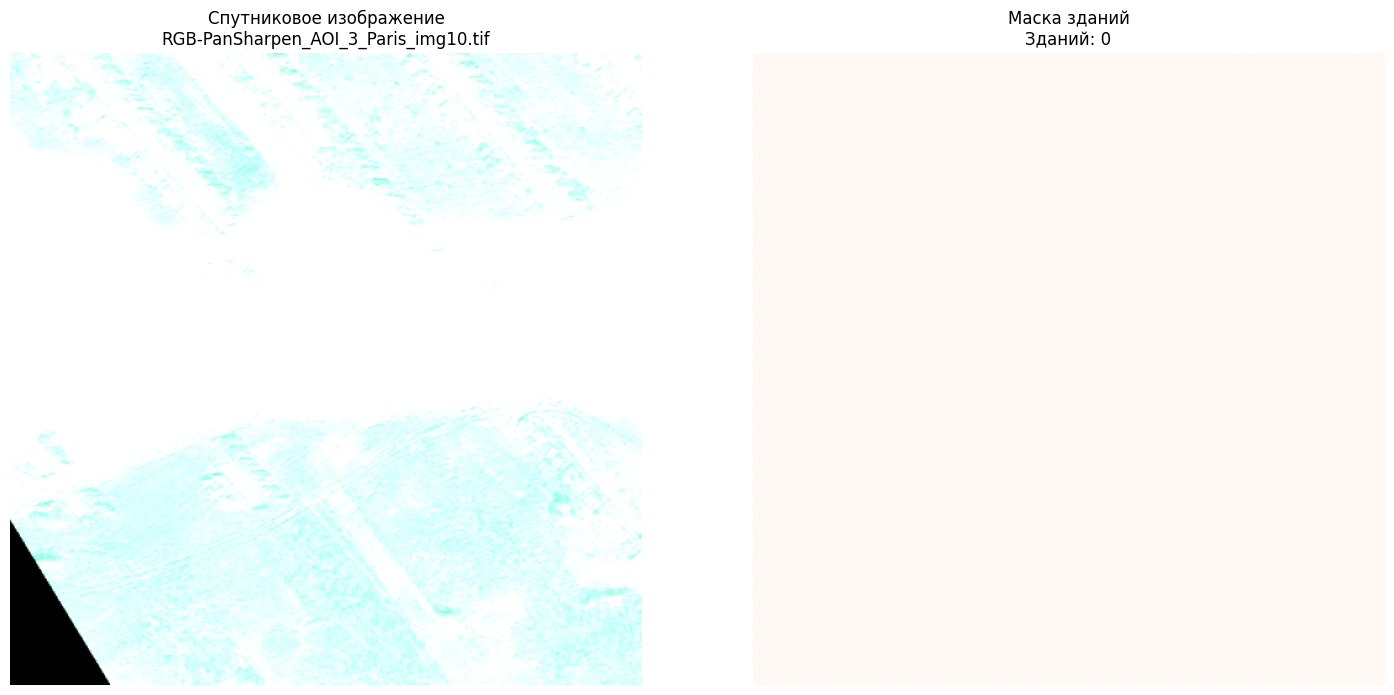


🔍 Ищем изображение с максимумом зданий...
🏆 Лучшее изображение: RGB-PanSharpen_AOI_3_Paris_img1129.tif
🔥 Максимум зданий: 112,969 пикселей


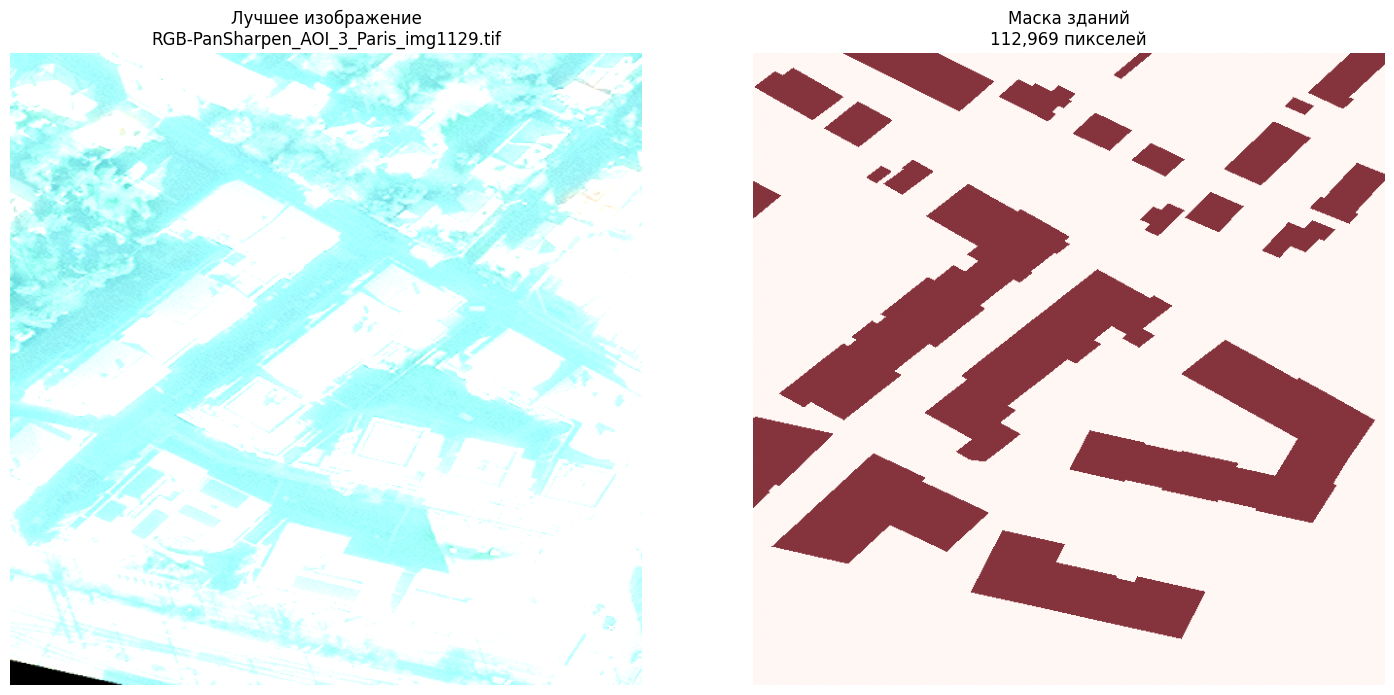

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Загружаем первый пример (КОРРЕКТНО для словаря)
sample = dataset[0]
image = sample['image']    # torch.Size([3, 512, 512])
mask = sample['mask']      # torch.Size([1, 650, 650])
resolution = sample['resolution']
name = sample['name']

print(f"Размер изображения: {image.shape}")
print(f"Размер маски: {mask.shape}")
print(f"Разрешение: {resolution}")
print(f"Файл: {name}")
print(f"Здания: {(mask > 0).sum().item()} пикселей")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# ✅ ИСПРАВЛЕННАЯ денормализация (ImageNet stats)
img_display = image.permute(1, 2, 0).cpu().numpy()
img_display = (img_display * np.array([0.229, 0.224, 0.225]) +
               np.array([0.485, 0.456, 0.406])).clip(0, 1)

# Отображаем
axes[0].imshow(img_display)
axes[0].set_title(f'Спутниковое изображение\n{name}', fontsize=12)
axes[0].axis('off')

# Маска (оригинальный размер 650x650)
mask_np = mask.squeeze().cpu().numpy()
axes[1].imshow(mask_np, cmap='Reds', alpha=0.7, vmin=0, vmax=1)
axes[1].set_title(f'Маска зданий\nЗданий: {(mask > 0).sum().item():,}', fontsize=12)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# 🔥 ПОИЩЕМ изображение С ЗДАНИЯМИ (из предыдущего DEBUG)
print("\n🔍 Ищем изображение с максимумом зданий...")
max_buildings = 0
best_idx = 0
for i in range(min(100, len(dataset))):
    sample = dataset[i]
    buildings = (sample['mask'] > 0).sum().item()
    if buildings > max_buildings:
        max_buildings = buildings
        best_idx = i

print(f"🏆 Лучшее изображение: {dataset[best_idx]['name']}")
print(f"🔥 Максимум зданий: {max_buildings:,} пикселей")

# Визуализируем ЛУЧШЕЕ изображение
best_sample = dataset[best_idx]
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

img_display = (best_sample['image'].permute(1, 2, 0).cpu().numpy() *
              np.array([0.229, 0.224, 0.225]) +
              np.array([0.485, 0.456, 0.406])).clip(0, 1)

axes[0].imshow(img_display)
axes[0].set_title(f'Лучшее изображение\n{best_sample["name"]}', fontsize=12)
axes[0].axis('off')

mask_np = best_sample['mask'].squeeze().cpu().numpy()
axes[1].imshow(mask_np, cmap='Reds', alpha=0.8, vmin=0, vmax=1)
axes[1].set_title(f'Маска зданий\n{max_buildings:,} пикселей', fontsize=12)
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from pathlib import Path

# ✅ ОДИН КОД ДЛЯ ВСЕГО
root = Path('/content/spacenet_data/AOI_3_Paris_Train')

print("✅ SpaceNet 2 Paris:")
print(f"Изображений: {len(list((root / 'RGB-PanSharpen').glob('*.tif')))}")
print(f"GeoJSON:     {len(list((root / 'geojson/buildings').glob('*.geojson')))}")
print("ВСЁ ГОТОВО!")


✅ SpaceNet 2 Paris:
Изображений: 1148
GeoJSON:     1148
ВСЁ ГОТОВО!


Model и лоссы для обучения,будем использовать для сегментации DeepLab3VPlus от гугл созданную специально для работы со спутниковыми снимками

In [ ]:
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    classes=1,
    activation=None
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [ ]:
import torch.nn.functional as F
class DiceLoss(torch.nn.Module):
  def forward(self, pred, target, smooth=1):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(2,3))
    dice = (2.*intersection + smooth) / (pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) + smooth)
    return 1 - dice.mean()

bce_loss = torch.nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()

def combined_loss(pred, target):
    target_resized = F.interpolate(target, size=pred.shape[-2:], mode='nearest')
    pred = torch.sigmoid(pred)

    bce = F.binary_cross_entropy_with_logits(pred, target_resized)
    intersection = (pred * target_resized).sum(dim=(2,3))
    dice = (2.*intersection + 1) / (pred.sum(dim=(2,3)) + target_resized.sum(dim=(2,3)) + 1)
    return 0.5 * bce + 0.5 * (1 - dice.mean())

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
for epoch in range(10):
    model.train()
    for batch in dataloader:
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}: Loss {loss.item()}")

torch.save(model.state_dict(), 'deeplab_model.pth')

Epoch 0: Loss 0.5485216379165649
Epoch 1: Loss 0.6765235662460327
Epoch 2: Loss 0.7394415736198425
Epoch 3: Loss 0.5172131657600403
Epoch 4: Loss 0.4863344430923462
Epoch 5: Loss 0.4582785367965698
Epoch 6: Loss 0.43129047751426697
Epoch 7: Loss 0.4688890278339386
Epoch 8: Loss 0.4126777648925781
Epoch 9: Loss 0.409216046333313


In [ ]:
from torch.utils.data import random_split

# Early Stopping параметры
patience = 7  # Сколько эпох терпеть без улучшения
min_delta = 0.001  # Минимальное улучшение для обновления лучшего результата

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=0)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)}")

# Инициализация Early Stopping
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(100):
    # TRAIN
    model.train()
    train_loss = 0
    for batch in train_loader:
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)
        outputs = model(images)
        loss = combined_loss(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # VAL
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            outputs = model(images)
            val_loss += combined_loss(outputs, masks).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch:2d}: Train {avg_train_loss:.4f} | Val {avg_val_loss:.4f}")

    # Early Stopping + Сохранение лучшей модели
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Сброс счётчика
        torch.save(model.state_dict(), 'best_deeplab_paris.pth')
        print(f"💾 Новая лучшая модель! Val Loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"⏳ Без улучшений: {patience_counter}/{patience}")

        # Early Stopping условие
        if patience_counter >= patience:
            print(f"🛑 Early Stopping на эпохе {epoch+1}! Лучший Val Loss: {best_val_loss:.4f}")
            break

print(f"✅ Обучение завершено. Лучшая модель сохранена.")

# 4. Тестирование на img721 (29 зданий)
# 4. Тестирование на img721 (29 зданий) - ИСПРАВЛЕННАЯ ВЕРСИЯ
model.load_state_dict(torch.load('best_deeplab_paris.pth', map_location=device))
model.to(device)  # ✅ Перемещаем модель на тот же device
model.eval()

with torch.no_grad():
    sample = dataset[721]

    # ✅ ПЕРЕМЕЩАЕМ ВСЕ НА ОДИН DEVICE
    input_tensor = sample['image'].unsqueeze(0).to(device)
    target_mask = sample['mask'].unsqueeze(0).to(device)  # Добавили .unsqueeze(0)

    pred = torch.sigmoid(model(input_tensor))
    pred_resized = F.interpolate(pred, size=target_mask.shape[-2:], mode='bilinear')

    # ✅ Вычисляем метрики НА GPU (быстрее!)
    pred_binary = (pred_resized > 0.5).float()
    target_binary = (target_mask > 0).float()

    real_buildings = target_binary.sum().item()
    pred_buildings = pred_binary.sum().item()

    # ✅ IoU формула (все тензоры на одном устройстве)
    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum() - intersection
    iou = (intersection / union).item() if union > 0 else 0.0

print(f"\n🏆 ТЕСТ НА img721:")
print(f"Реальных зданий: {real_buildings:,} пикселей")
print(f"Предсказанных:    {pred_buildings:,} пикселей")
print(f"IoU: {iou:.3f}")



Train: 918 | Val: 230
Epoch  0: Train 0.4447 | Val 0.4183
💾 Новая лучшая модель! Val Loss: 0.4183
Epoch  1: Train 0.4359 | Val 0.4193
⏳ Без улучшений: 1/7
Epoch  2: Train 0.4418 | Val 0.4091
💾 Новая лучшая модель! Val Loss: 0.4091
Epoch  3: Train 0.4278 | Val 0.4122
⏳ Без улучшений: 1/7
Epoch  4: Train 0.4433 | Val 0.4490
⏳ Без улучшений: 2/7
Epoch  5: Train 0.4228 | Val 0.4113
⏳ Без улучшений: 3/7
Epoch  6: Train 0.4264 | Val 0.4141
⏳ Без улучшений: 4/7
Epoch  7: Train 0.4368 | Val 0.4077
💾 Новая лучшая модель! Val Loss: 0.4077
Epoch  8: Train 0.4215 | Val 0.4109
⏳ Без улучшений: 1/7
Epoch  9: Train 0.4352 | Val 0.4072
⏳ Без улучшений: 2/7
Epoch 10: Train 0.4214 | Val 0.4421
⏳ Без улучшений: 3/7
Epoch 11: Train 0.4439 | Val 0.4352
⏳ Без улучшений: 4/7
Epoch 12: Train 0.4481 | Val 0.4176
⏳ Без улучшений: 5/7
Epoch 13: Train 0.4362 | Val 0.4087
⏳ Без улучшений: 6/7
Epoch 14: Train 0.4213 | Val 0.4124
⏳ Без улучшений: 7/7
🛑 Early Stopping на эпохе 15! Лучший Val Loss: 0.4077
✅ Обучение з

Для расчета растояния попробуем использовать классы эталоны,то есть объекты,которые имеют сторогие нормативы по своим размерам,на них мы и будем пологаться для расчета маштаба

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.2 MB/s eta 0:00:00


In [ ]:
class DetectedObject(NamedTuple):
  calss_name: str
  length_in_pizels: float
  confidence: float

REFERENCE_SIZES = {
    "car": 4.65,  # средняя длина легкового авто
    "bus": 12.0,   # стандартный автобус
    "truck": 16.5, # грузовик с прицепом
    "shipping_container": 12.2,  # 40ft контейнер
    "tennis_court": 23.77,  # длина корта
    "tennis_court_width": 10.97,  # ширина корта
    "basketball_court": 28.0,  # длина
    "soccer_field": 105.0,  # максимальная длина
    "soccer_field_min": 90.0,  # минимальная длина
    "parking_space": 2.5,  # стандартное парковочное место
    "road_lane": 3.5,  # ширина полосы
}

In [ ]:
import cv2
import numpy as np
import statistics
from typing import List, NamedTuple, Optional, Tuple
from ultralytics import YOLO
import torch

# 1. ОПРЕДЕЛЕНИЕ СТРУКТУРЫ ДАННЫХ
class DetectedObject(NamedTuple):
    """Структура для хранения информации об обнаруженном объекте"""
    class_name: str
    length_in_pixels: float
    confidence: float

# 2. ПРАВИЛЬНЫЕ ЭТАЛОННЫЕ РАЗМЕРЫ (в метрах)
REFERENCE_SIZES = {
    "car": 4.65,                        # средняя длина автомобиля
    "truck": 9.0,                       # грузовик без прицепа
    "truck_with_trailer": 16.5,         # грузовик с прицепом
    "bus": 12.0,                        # стандартный автобус
    "shipping_container": 12.2,         # 40ft контейнер (12.2м)
    "shipping_container_20ft": 6.1,     # 20ft контейнер
    "tennis_court": 23.77,              # ДЛИНА теннисного корта (не ширина!)
    "tennis_court_width": 10.97,        # ширина теннисного корта
    "basketball_court": 28.0,           # длина баскетбольной площадки
    "soccer_field_max": 105.0,          # максимальная длина футбольного поля
    "soccer_field_min": 90.0,           # минимальная длина футбольного поля
    "parking_space": 2.5,               # стандартное парковочное место
    "road_lane": 3.5,                   # ширина полосы движения
    "swimming_pool": 50.0,              # олимпийский бассейн
}

# 3. НАСТРОЙКИ ДЕТЕКЦИИ
YOLO_CONFIDENCE_THRESHOLD = 0.5
MIN_OBJECT_SIZE_PX = 15              # минимальный размер объекта в пикселях
VALID_OBJECT_TYPES = ["car", "truck", "bus"]

# 4. ИНИЦИАЛИЗАЦИЯ YOLO (один раз)
yolo_model = YOLO('yolov8n.pt')      # yolov8n.pt быстрее для тестов

# 🔥 НОВЫЕ ФУНКЦИИ ДЛЯ torch.Tensor ИЗ ДАТАСЕТА
def tensor_to_cv2_image(image_tensor: torch.Tensor) -> np.ndarray:
    """Конвертирует torch.Tensor [3,H,W] → cv2 BGR [H,W,3] с денормализацией ImageNet"""
    # [3,H,W] → [H,W,3] RGB
    img_np = image_tensor.permute(1, 2, 0).cpu().numpy()

    # ImageNet normalization stats
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Денормализация
    img_normalized = (img_np * std + mean).clip(0, 1)

    # Конвертация в [0,255] uint8
    img_uint8 = (img_normalized * 255).astype(np.uint8)

    # RGB → BGR для OpenCV
    return cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)

def calculate_gsd(detected_objects: List[DetectedObject]) -> Optional[float]:
    """Рассчитывает GSD на основе обнаруженных объектов"""
    if not detected_objects:
        print("⚠️ Не обнаружено объектов для калибровки")
        return None

    estimates = []
    object_counts = {}

    for obj in detected_objects:
        class_name = obj.class_name.lower()

        # Проверяем, есть ли эталонный размер для этого класса
        if class_name not in REFERENCE_SIZES:
            continue

        # Проверка доверия и размера
        if obj.confidence < 0.5:
            continue

        if obj.length_in_pixels < MIN_OBJECT_SIZE_PX:
            continue

        # Получаем реальный размер
        real_size = REFERENCE_SIZES[class_name]

        # Рассчитываем GSD
        gsd_estimate = real_size / obj.length_in_pixels

        # Фильтрация разумных значений GSD (0.05-5.0 м/пиксель)
        if 0.05 <= gsd_estimate <= 5.0:
            estimates.append(gsd_estimate)
            object_counts[class_name] = object_counts.get(class_name, 0) + 1
            print(f"  ✓ {class_name}: {obj.length_in_pixels:.1f}px → GSD={gsd_estimate:.4f} м/px (conf={obj.confidence:.2f})")

    if not estimates:
        print("⚠️ Не найдено подходящих объектов для калибровки масштаба")
        return None

    # Используем медиану для устойчивости к выбросам
    final_gsd = statistics.median(estimates)

    print(f"\n📏 GSD определен: {final_gsd:.4f} м/пиксель")
    print(f"   На основе {len(estimates)} объектов: {object_counts}")
    print(f"   Диапазон оценок: {min(estimates):.4f} - {max(estimates):.4f} м/px")

    return final_gsd

def detect_cars_with_yolo(image_rgb: np.ndarray) -> List[DetectedObject]:
    """Обнаружение автомобилей с помощью YOLOv8"""
    objects = []

    # Выполняем детекцию
    results = yolo_model(image_rgb, verbose=False)[0]

    for box in results.boxes:
        class_id = int(box.cls)
        class_name = results.names[class_id]
        confidence = float(box.conf)

        # Нас интересуют только автомобили, грузовики, автобусы
        if class_name not in VALID_OBJECT_TYPES:
            continue

        if confidence < YOLO_CONFIDENCE_THRESHOLD:
            continue

        # Получаем размеры bounding box
        x_center, y_center, width_px, height_px = box.xywh[0].tolist()

        # Используем длину (максимальный размер)
        length_px = max(width_px, height_px)

        # Фильтр по минимальному размеру
        if length_px < MIN_OBJECT_SIZE_PX:
            continue

        objects.append(DetectedObject(
            class_name=class_name,
            length_in_pixels=float(length_px),
            confidence=confidence
        ))

    return objects

def detect_rectangular_objects(image_rgb: np.ndarray) -> List[DetectedObject]:
    """Обнаружение прямоугольных объектов (корты, поля) с помощью OpenCV"""
    objects = []

    # Конвертируем в grayscale
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

    # Детекция краев
    edges = cv2.Canny(gray, 50, 150)

    # Находим контуры
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Пропускаем слишком маленькие контуры
        area = cv2.contourArea(contour)
        if area < 1000:
            continue

        # Находим минимальный ограничивающий прямоугольник
        rect = cv2.minAreaRect(contour)
        width_px, height_px = rect[1]

        # Определяем длину и ширину (длина всегда больше)
        length_px = max(width_px, height_px)
        width_small = min(width_px, height_px)

        if width_small == 0:
            continue

        # Соотношение сторон
        aspect_ratio = length_px / width_small

        # Определяем тип объекта по соотношению сторон и размеру
        # Теннисный корт: ~23.77м x 10.97м = соотношение ~2.17
        if 1.9 < aspect_ratio < 2.5 and area > 5000:
            objects.append(DetectedObject(
                class_name="tennis_court",
                length_in_pixels=float(length_px),
                confidence=0.9  # Высокая уверенность для правильных пропорций
            ))

        # Баскетбольная площадка: ~28м x 15м = соотношение ~1.87
        elif 1.7 < aspect_ratio < 2.0 and area > 8000:
            objects.append(DetectedObject(
                class_name="basketball_court",
                length_in_pixels=float(length_px),
                confidence=0.8
            ))

        # Футбольное поле: ~105м x 68м = соотношение ~1.54
        elif 1.4 < aspect_ratio < 1.7 and area > 20000:
            objects.append(DetectedObject(
                class_name="soccer_field_max",  # Используем максимальный размер
                length_in_pixels=float(length_px),
                confidence=0.7
            ))

    return objects

def get_detected_objects_hybrid_from_array(image_rgb: np.ndarray) -> List[DetectedObject]:
    """Собирает объекты из различных методов детекции для numpy array"""
    objects = []

    print(f"   🔍 Детекция объектов...")

    # 1. Детекция с помощью YOLO (автомобили, грузовики)
    yolo_objects = detect_cars_with_yolo(image_rgb)
    print(f"   🚗 YOLO: обнаружено {len(yolo_objects)} объектов")
    objects.extend(yolo_objects)

    # 2. Детекция прямоугольных объектов (OpenCV)
    cv_objects = detect_rectangular_objects(image_rgb)
    print(f"   📐 OpenCV: обнаружено {len(cv_objects)} объектов")
    objects.extend(cv_objects)

    return objects

def estimate_gsd_from_sample(sample: dict, fallback_gsd: float = 0.3) -> float:
    """🎯 ГЛАВНАЯ ФУНКЦИЯ: оценивает GSD для одного сэмпла из PyTorch Dataset"""
    print(f"\n{'='*60}")
    print(f"🔍 Анализ изображения: {sample['name']}")
    print(f"   Размер: {sample['image'].shape}")
    print(f"{'='*60}")

    # 1. Конвертируем torch.Tensor → cv2
    image_bgr = tensor_to_cv2_image(sample['image'])
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # 2. Получаем все обнаруженные объекты
    detected_objects = get_detected_objects_hybrid_from_array(image_rgb)

    # 3. Рассчитываем GSD
    gsd = calculate_gsd(detected_objects)

    if gsd is None:
        print(f"⚠️  Используем fallback GSD: {fallback_gsd} м/пиксель")
        return fallback_gsd

    return gsd

def calculate_building_area(mask: torch.Tensor, gsd: float) -> float:
    """Рассчитывает площадь зданий в квадратных метрах из маски датасета"""
    # Конвертируем torch.Tensor в numpy
    mask_np = mask.squeeze().cpu().numpy()

    # Подсчитываем пиксели зданий
    building_pixels = np.sum(mask_np > 0.5)

    # Конвертируем в квадратные метры
    pixel_area_m2 = gsd ** 2  # площадь одного пикселя в м²
    total_area_m2 = building_pixels * pixel_area_m2

    return total_area_m2

# 🚀 ПРИМЕР ИСПОЛЬЗОВАНИЯ С ВАШИМ ДАТАСЕТОМ
if __name__ == "__main__":
    print("🚀 GSD КАЛИБРОВКА ДЛЯ СПУТНИКОВЫХ СНИМКОВ")
    print("=" * 60)

    # 🔥 ТЕСТ НА ЛУЧШЕМ ИЗОБРАЖЕНИИ С ЗДАНИЯМИ
    print("\n1. Берем лучшее изображение с максимумом зданий...")
    best_sample = dataset[best_idx]

    # Оцениваем GSD
    gsd = estimate_gsd_from_sample(best_sample)

    # Вычисляем площадь зданий в м²
    building_area = calculate_building_area(best_sample['mask'], gsd)

    print(f"\n🏆 РЕЗУЛЬТАТ ДЛЯ ЛУЧШЕГО ИЗОБРАЖЕНИЯ:")
    print(f"   📄 Имя: {best_sample['name']}")
    print(f"   📏 GSD: {gsd:.4f} м/пиксель")
    print(f"   🏢 Площадь зданий: {building_area:,.0f} м²")
    print(f"   🔢 Пикселей зданий: {(best_sample['mask'] > 0).sum().item():,} px")

    print("\n" + "="*60)
    print("✅ ГОТОВО! Код полностью адаптирован для PyTorch Dataset")


In [ ]:
import cv2
import numpy as np
import torch
import statistics
from typing import List, NamedTuple, Optional
from ultralytics import YOLO

# 1. СТРУКТУРА ДАННЫХ
class DetectedObject(NamedTuple):
    class_name: str
    length_in_pixels: float
    confidence: float

# 2. РАСШИРЕННЫЕ ЭТАЛОНЫ (С ВЕСАМИ НАДЕЖНОСТИ)
# Вес (от 0 до 1) определяет, насколько мы доверяем объекту при расчете GSD
REFERENCE_DATA = {
    "tennis_court": {"size": 23.77, "weight": 1.0},
    "basketball_court": {"size": 28.0, "weight": 0.9},
    "car": {"size": 4.5, "weight": 0.5},  # Машины разные, поэтому вес ниже
    "bus": {"size": 12.0, "weight": 0.8},
    "truck": {"size": 9.0, "weight": 0.7},
    "shipping_container": {"size": 12.2, "weight": 0.9}
}

# 3. ЗАГРУЗКА МОДЕЛИ (OBB - Oriented Bounding Boxes)
# yolov8n-obb идеально подходит для вида сверху
try:
    model = YOLO('yolov8n-obb.pt')
except:
    model = YOLO('yolov8n.pt') # Fallback если OBB не доступен

def get_robust_gsd(detections: List[DetectedObject]) -> Optional[float]:
    """Вычисляет GSD, используя веса и фильтрацию выбросов (IQR)"""
    if not detections:
        return None

    estimates = []
    weights = []

    for obj in detections:
        name = obj.class_name.lower()
        if name in REFERENCE_DATA:
            ref = REFERENCE_DATA[name]
            gsd_val = ref["size"] / obj.length_in_pixels

            # Предварительный фильтр: GSD в космосе/дронах обычно от 0.05 до 5.0
            if 0.05 <= gsd_val <= 5.0:
                estimates.append(gsd_val)
                weights.append(ref["weight"])

    if len(estimates) < 1:
        return None

    # Фильтрация выбросов через межквартильный размах (IQR)
    estimates_np = np.array(estimates)
    if len(estimates_np) >= 4:
        q1, q3 = np.percentile(estimates_np, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Оставляем только те, что в границах
        valid_idx = np.where((estimates_np >= lower_bound) & (estimates_np <= upper_bound))[0]
        if len(valid_idx) > 0:
            final_estimates = estimates_np[valid_idx]
            final_weights = np.array(weights)[valid_idx]
            return float(np.average(final_estimates, weights=final_weights))

    return float(np.average(estimates, weights=weights))

def run_inference_with_slicing(image_rgb: np.ndarray, slice_size=256, overlap=0.2) -> List[DetectedObject]:
    """Нарезает изображение на части (Slicing), чтобы найти мелкие объекты"""
    h, w, _ = image_rgb.shape
    step = int(slice_size * (1 - overlap))
    all_detections = []

    # Если изображение маленькое, прогоняем целиком
    if h <= slice_size and w <= slice_size:
        slices = [(0, 0, image_rgb)]
    else:
        slices = []
        for y in range(0, h - slice_size + 1, step):
            for x in range(0, w - slice_size + 1, step):
                slices.append((x, y, image_rgb[y:y+slice_size, x:x+slice_size]))

    for x_offset, y_offset, img_slice in slices:
        results = model(img_slice, verbose=False, conf=0.3)[0]

        # Обработка OBB (ориентированных боксов)
        if hasattr(results, 'obb') and results.obb is not None:
            for i in range(len(results.obb.cls)):
                cls_id = int(results.obb.cls[i])
                name = results.names[cls_id]
                # В OBB берем длину длинной стороны
                w_px = results.obb.xywhr[i][2].item()
                h_px = results.obb.xywhr[i][3].item()

                all_detections.append(DetectedObject(
                    class_name=name,
                    length_in_pixels=max(w_px, h_px),
                    confidence=float(results.obb.conf[i])
                ))
        # Обработка обычных боксов (если OBB не сработал)
        else:
            for box in results.boxes:
                cls_id = int(box.cls)
                name = results.names[cls_id]
                _, _, w_px, h_px = box.xywh[0].tolist()
                all_detections.append(DetectedObject(
                    class_name=name,
                    length_in_pixels=max(w_px, h_px),
                    confidence=float(box.conf)
                ))

    return all_detections

def test_on_sample(sample):
    """Тестовая функция для одного сэмпла из датасета"""
    print(f"\n--- Тест: {sample.get('name', 'Unknown')} ---")

    # Конвертация тензора в формат для CV2
    img_tensor = sample['image']
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * 255).astype(np.uint8)
    img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    # 1. Детекция с слайсингом
    detections = run_inference_with_slicing(img_np)
    print(f"Найдено потенциальных объектов: {len(detections)}")

    # 2. Расчет масштаба (GSD)
    gsd = get_robust_gsd(detections)

    if gsd:
        print(f"🎯 Определенный масштаб: {gsd:.4f} м/пиксель")

        # 3. Расчет площади зданий из маски
        mask = sample['mask'].cpu().numpy()
        building_pixels = np.sum(mask > 0.5)
        area_m2 = building_pixels * (gsd ** 2)
        print(f"🏢 Площадь зданий: {area_m2:,.1f} м²")
    else:
        print("⚠️ Не удалось определить масштаб. Объекты не найдены или отфильтрованы.")

# ПРИМЕР ЗАПУСКА
test_on_sample(dataset[1129])